In [17]:
pip install pandas matplotlib surprise

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise import accuracy

In [19]:
ratings_url = 'https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv'
movies_url = 'https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv'

ratings = pd.read_csv(ratings_url)
movies = pd.read_csv(movies_url)

In [20]:
merged_data = pd.merge(ratings, movies, on='movieId')

In [21]:
sci_fi_movies = merged_data[merged_data['genres'].str.contains("Sci-Fi")].shape[0]
print("Number of Sci-Fi movies:", sci_fi_movies)

Number of Sci-Fi movies: 17243


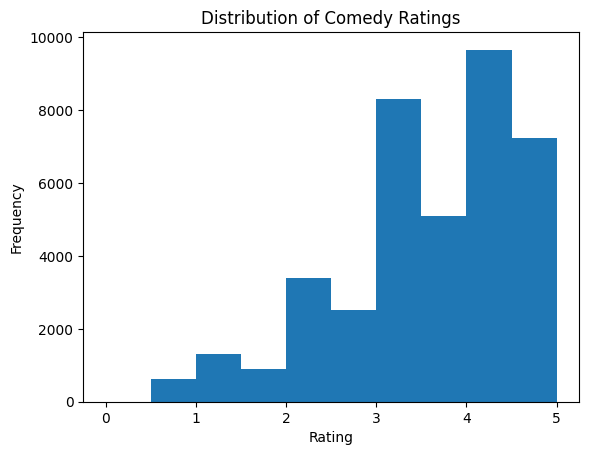

In [22]:
comedy_ratings = merged_data[merged_data['genres'].str.contains("Comedy")]['rating']
plt.hist(comedy_ratings, bins=10, range=(0, 5))
plt.title("Distribution of Comedy Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [23]:
action_movies = merged_data[merged_data['genres'].str.contains("Action")]
avg_action_rating = action_movies['rating'].mean()
top_3_action_movies = action_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(3)
print("Average rating of all action movies:", avg_action_rating)
print("Top 3 highest-rated action movies:\n", top_3_action_movies)

Average rating of all action movies: 3.447984331646809
Top 3 highest-rated action movies:
 title
Knock Off (1998)                                                      5.0
On the Other Side of the Tracks (De l'autre côté du périph) (2012)    5.0
Sonatine (Sonachine) (1993)                                           5.0
Name: rating, dtype: float64


In [24]:
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [25]:
svd = SVD()
svd_result = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8756  0.8672  0.8756  0.8804  0.8739  0.8745  0.0043  
MAE (testset)     0.6759  0.6665  0.6727  0.6767  0.6693  0.6722  0.0039  
Fit time          2.60    2.86    3.23    5.12    3.20    3.40    0.89    
Test time         0.26    0.24    0.65    0.49    0.31    0.39    0.16    


In [26]:
knn_options = {'name': 'pearson', 'user_based': True}
knn_with_means = KNNWithMeans(sim_options=knn_options)

In [27]:
param_grid = {'k': range(2, 7)}
gs_knn = GridSearchCV(KNNWithMeans, param_grid, measures=['RMSE', 'MAE'], cv=5)
gs_knn.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [28]:
best_knn_structure = gs_knn.best_estimator
print("Best kNN Structure:", best_knn_structure)

Best kNN Structure: {'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7d7e408bb070>, 'mae': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7d7e408bb160>}


In [29]:
best_knn = gs_knn.best_estimator['rmse']

print(f"Best kNN config: k={gs_knn.best_params['rmse']['k']}")

Best kNN config: k=6


In [30]:
trainset, testset = train_test_split(data, test_size=0.2)
best_knn.fit(trainset)
predictions_knn = best_knn.test(testset)
rmse_knn = accuracy.rmse(predictions_knn, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9173


In [31]:
def get_movie_id(title):
    movie_id = movies[movies['title'].str.contains(title, case=False, na=False)]['movieId'].values
    if len(movie_id) > 0:
        return movie_id[0]
    return None

def recommend_after_movie(algo, movie_title, top_n=5):
    movie_id = get_movie_id(movie_title)
    if movie_id is None:
        print(f"Movie '{movie_title}' not found.")
        return

    user_ids = merged_data[merged_data['movieId'] == movie_id]['userId'].unique()
    potential_recommendations = set(merged_data['movieId'])

    for uid in user_ids:
        rated_movies = set(merged_data[merged_data['userId'] == uid]['movieId'])
        potential_recommendations -= rated_movies

    recommendations = [(mid, algo.predict(uid, mid).est) for mid in potential_recommendations]
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)

    print(f"Top {top_n} recommendations after watching '{movie_title}':")
    for mid, score in recommendations[:top_n]:
        title = movies[movies['movieId'] == mid]['title'].values[0]
        print(f"Movie: {title}, Predicted Rating: {score}")

In [32]:
print("\nRecommendations after watching 'Jumanji':")
recommend_after_movie(best_knn, "Jumanji")


Recommendations after watching 'Jumanji':
Top 5 recommendations after watching 'Jumanji':
Movie: Bossa Nova (2000), Predicted Rating: 5.0
Movie: Galaxy of Terror (Quest) (1981), Predicted Rating: 5.0
Movie: Looker (1981), Predicted Rating: 5.0
Movie: Alien Contamination (1980), Predicted Rating: 5.0
Movie: Match Factory Girl, The (Tulitikkutehtaan tyttö) (1990), Predicted Rating: 5.0


In [33]:
print("\nRecommendations after watching 'Flint':")
recommend_after_movie(best_knn, "Flint")


Recommendations after watching 'Flint':
Top 5 recommendations after watching 'Flint':
Movie: It's Such a Beautiful Day (2012), Predicted Rating: 5.0
Movie: Beloved (1998), Predicted Rating: 5.0
Movie: Bossa Nova (2000), Predicted Rating: 5.0
Movie: Galaxy of Terror (Quest) (1981), Predicted Rating: 5.0
Movie: Looker (1981), Predicted Rating: 5.0
